MeshNet architecture based on https://arxiv.org/pdf/1612.00940.pdf

"End-to-end learning of brain tissue segmentation
from imperfect labeling"
Jun 2017
Alex Fedorov∗†, Jeremy Johnson‡
, Eswar Damaraju∗†, Alexei Ozerin§
, Vince Calhoun∗†, Sergey Plis∗†

# Libraries and Global Parameters 

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte, img_as_int
from skimage.transform import resize
from skimage.morphology import label
import random
from random import randint 
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout, Flatten
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy


####### UPDATE THIS #########
#############################

model_num = 19

#############################
#############################

model_checkpoint_file= 'meshnet_v' + str(model_num) +'.h5'
submission_filename = 'meshnet_v' + str(model_num) +'_mesh_pred.csv'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128
img_channels = 1 # 1 for B&W, 3 for RGB

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#warnings.resetwarnings()

Using TensorFlow backend.


# Preparing the Data

In [2]:
# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    resized_images = [ resize(image,(img_width,img_height)) for image in images] 
    Array = np.reshape(np.array(resized_images),
                       (len(resized_images),img_height,img_width,img_channels))
    #Array = np.reshape(np.array(img_as_ubyte(resized_images),dtype=np.uint8).astype(np.uint8),
    #                   (len(resized_images),img_height,img_width,img_channels))
    
    print(Array.mean())
    print(Array.std())

    # Normalize inputs
    Array = ((Array - Array.mean())/Array.std())

    print(Array.mean())
    print(Array.std())
    print(images[0].dtype)
    print(resized_images[0].dtype)
    print(Array[0,0,0,0].dtype)
    return Array, resized_images, images, filenames, dirs

train_X, resized_train_images, \
train_images, train_filenames, train_dirs = import_images(train_root)

0.160902796657
0.249621650769
1.26292011674e-15
1.0
float64
float64
float64


In [3]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]
resized_train_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] 
train_Y = np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,img_channels))

Image #: 124


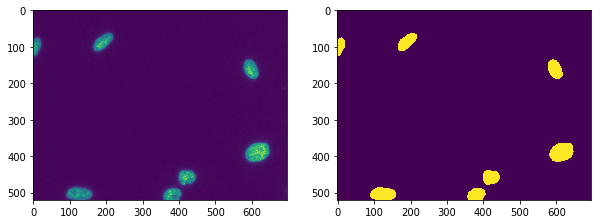

In [4]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num,size=(15,10)):
    print('Image #: ' + str(image_num))
    fig = plt.figure(figsize=size)

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])

    plt.show()
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None,size=(15,10)):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1),size=size)
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i],size=size)
    

plot_check([train_images,train_masks],rand_imgs=1,size=(10,7))


In [5]:
# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time

# Check physical size
print(train_X.shape)
print(train_Y.shape)

# Check memory size
print(train_X.nbytes)
print(train_Y.nbytes)

# Check datatypes
print(train_X.dtype)
print(train_Y.dtype)

(670, 128, 128, 1)
(670, 128, 128, 1)
87818240
10977280
float64
bool


Image #: 60


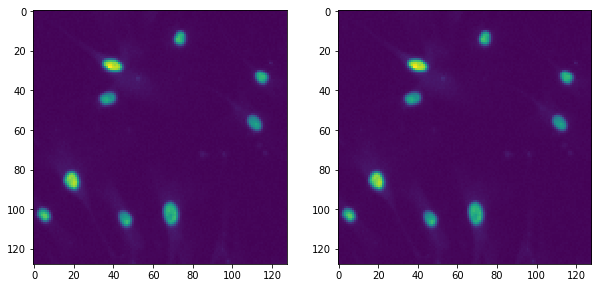

In [6]:
plot_check([np.squeeze(train_X,axis=3),],rand_imgs=1,size=(10,7))


# Now Let's Build the Model

In [17]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def create_block(x, filters=21, filter_size=(3, 3), activation='relu',dil_rate=1,dropout_rate=0.25,l2_reg=0):
    x = Conv2D(filters, filter_size, padding='same', activation=activation, dilation_rate = dil_rate,kernel_regularizer=regularizers.l2(l2_reg)) (x)
    #x = BatchNormalization() (x) 
   # x = Dropout(dropout_rate) (x)
    return x


## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,img_channels),
        loss=binary_crossentropy,
        lr=0.001,
        n_class=1,
        nb_filters=21,
        dropout=0.2
):
    
    inputs = Input(input_shape)
    
    # Create layers
    net_body = create_block(inputs,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=2)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=4)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=8)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[bce_dice_loss, dice_coef])

    return model

#### CREATE MODEL ##########################################################

my_model = get_net(nb_filters=21,dropout=0.1,loss=binary_crossentropy)

############################################################################

print(my_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 21)      210       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 21)      3990      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 21)      3990      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 128, 21)      3990      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 128, 128, 21)      3990      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 128, 128, 21)      3990      
__________

In [18]:
# Fit model

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,
                           patience=4,
                           verbose=1,
                        #   min_lr=0.00001,
                            epsilon=0.001,
                           mode='auto') 

results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=5, epochs=100, verbose=1, 
                       shuffle=True, callbacks=[ earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/100
600/603 [============================>.] - ETA: 0s - loss: 0.3488 - bce_dice_loss: 1.0865 - dice_coef: 0.1333
Epoch 00001: val_loss improved from inf to 0.23379, saving model to meshnet_v19.h5
603/603 [==============================] - 184s 305ms/step - loss: 0.3482 - bce_dice_loss: 1.0847 - dice_coef: 0.1351 - val_loss: 0.2338 - val_bce_dice_loss: 0.7409 - val_dice_coef: 0.5604
Epoch 2/100
600/603 [============================>.] - ETA: 0s - loss: 0.1736 - bce_dice_loss: 0.5569 - dice_coef: 0.7277
Epoch 00002: val_loss improved from 0.23379 to 0.12210, saving model to meshnet_v19.h5
603/603 [==============================] - 182s 302ms/step - loss: 0.1734 - bce_dice_loss: 0.5566 - dice_coef: 0.7279 - val_loss: 0.1221 - val_bce_dice_loss: 0.3821 - val_dice_coef: 0.8039
Epoch 3/100
600/603 [============================>.] - ETA: 0s - loss: 0.1199 - bce_dice_loss: 0.3787 - dice_coef: 0.8230
Epoch 00003: val_loss improved from 0.122

600/603 [============================>.] - ETA: 0s - loss: 0.0715 - bce_dice_loss: 0.2250 - dice_coef: 0.8949
Epoch 00022: val_loss did not improve
603/603 [==============================] - 184s 305ms/step - loss: 0.0713 - bce_dice_loss: 0.2244 - dice_coef: 0.8952 - val_loss: 0.0698 - val_bce_dice_loss: 0.2294 - val_dice_coef: 0.8797
Epoch 23/100
600/603 [============================>.] - ETA: 0s - loss: 0.0702 - bce_dice_loss: 0.2264 - dice_coef: 0.8913
Epoch 00023: val_loss did not improve
603/603 [==============================] - 185s 307ms/step - loss: 0.0707 - bce_dice_loss: 0.2275 - dice_coef: 0.8907 - val_loss: 0.0697 - val_bce_dice_loss: 0.2356 - val_dice_coef: 0.8796
Epoch 24/100
600/603 [============================>.] - ETA: 0s - loss: 0.0709 - bce_dice_loss: 0.2256 - dice_coef: 0.8937
Epoch 00024: val_loss improved from 0.06953 to 0.06949, saving model to meshnet_v19.h5

Epoch 00024: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
603/603 [============

KeyboardInterrupt: 

In [29]:
for val_loss in results.history['val_loss']:
    print(round(val_loss,3))
#print(results.history)

NameError: name 'results' is not defined

In [9]:
## Import Test Data and Make Predictions with Model

# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
test_X, resized_test_images, \
test_images, test_filenames, test_dirs = import_images(test_root)


# Load model and make predictions on test data
final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) 

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

preds_test_upsampled_bool = [ (mask > 0.5).astype(bool) for mask in preds_test_upsampled ]


0.208730805725
0.293186881966
1.75073630806e-16
1.0
float64
float64
float64
65/65 [==============================] - 10s 156ms/step


Image #: 39


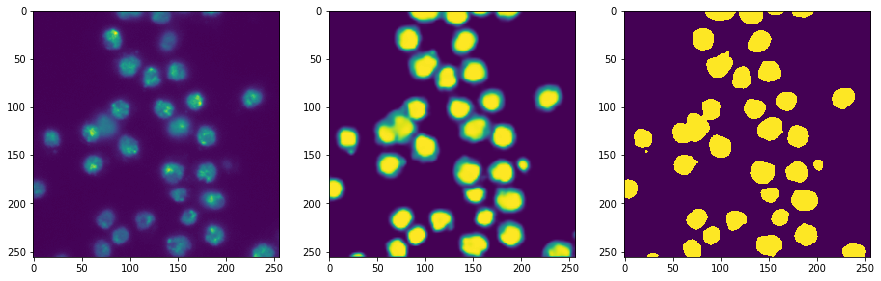

Image #: 58


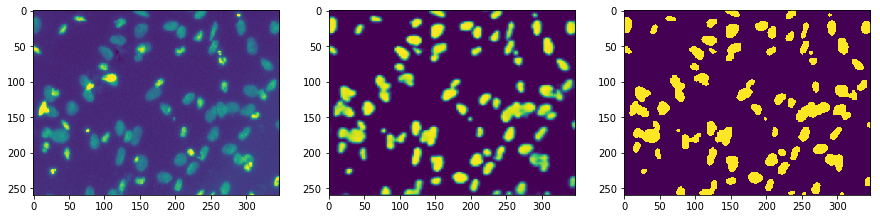

In [10]:
plot_check([test_images,preds_test_upsampled,preds_test_upsampled_bool],rand_imgs=2)

In [11]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

        
def generate_prediction_file(image_names,predictions,filename):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(image_names):
        rle = list(prob_to_rles(predictions[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(filename, index=False)

In [12]:
generate_prediction_file(test_dirs,preds_test_upsampled_bool,submission_filename)

Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data